In [116]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os
import pickle


#load the graph and the dictionary

#final_qubit_dictionary = np.load("./data/dict_qbit_to_lattice.npy", allow_pickle=True).item()
final_qubit_dictionary = np.load("./data/dict_qbit_to_lattice_periodic.npy", allow_pickle=True).flat[0]
Kag_graph = pickle.load(open('./data/Kag_graph_periodic.pickle', 'rb'))
#Kag_graph = pickle.load(open('./data/Kag_graph.pickle', 'rb'))

#test that it works
#nx.draw(Kag_graph, final_qubit_dictionary)


# Data

Import some data - first, the different h/J accessible.

In [194]:
folder_global = "../data_prathus_runs/APQ1/raw"

dict_h = {}
Jmax = 0.66
mainfolder = list(Path(folder_global).glob('*'))
#mainfolder = list(Path('./data/raw_apq_zx').glob('*'))
for foldername in mainfolder:
    h1 = str(foldername).split('/')[-1].split('=')[-1]
    if h1 != ".DS_Store" and h1 != ".DS_Store:Zone.Identifier":
        #print("h1=",h1)
        hJtag = "{:.3f}".format(float(h1)/Jmax)
        dict_h.update({hJtag:h1})
print("various h/J in folder: " + folder_global)
print(dict_h.keys())

various h/J in folder: ../data_prathus_runs/APQ1/raw
dict_keys(['0.000', '2.004', '3.908', '5.211', '0.501', '4.109', '2.505', '1.503', '0.251', '3.006', '3.507', '4.509', '1.002', '3.708', '6.012'])


In [201]:
#file_name = "./data/J=1.0__h1,h2,k2,s=1.04,0.52,-2.0,0__04-10-23__18-08-54.npz"
#file_name = "./data/J=1.0__h1,h2,k2,s=3.04,1.52,-2.0,0__04-10-23__18-09-45.npz"
# folder = "../data_prathus_runs/APQ1/raw/h1=0.6613701696385046/s=0.7"
folder = folder_global + "/h1=" + dict_h['3.006'] + "/s=0.7"
# folder = "../data_prathus_runs/APQ1/raw/h1=1.9841105089155138/s=0.7"
#folder = "../data_prathus_runs/APQ1/raw/h1=0.0/s=0.7"

mainfolder = list(Path(folder).glob('*'))
#mainfolder = list(Path('./data/raw_apq_zx').glob('*'))

reps = 0
folders_to_open = []
if len(mainfolder) != 0:
    print("success in finding this folder")
else:
    print('problem')
for foldername in mainfolder:
    if str(foldername)[-4:] == ".npz":
        #print(foldername)
        reps += 1
        folders_to_open.append(foldername)

# def open_file(path):
    
#     file=np.load(path)
    
#     resp=file['resp']
#     paramsarray=file['paramsarray']
#     missingqs=file['missingqs']
#     twochains=file['twochains']
#     nodes=file['final_nodes']
    
#     return resp,paramsarray,missingqs,twochains,nodes

all_configs = []
for k in range(len(folders_to_open)):
    file=np.load(folders_to_open[k])
    resps = file['resp']

    for i in range(len(resps)):
        frequency = resps[i][2]
        for freq in range(frequency):
            all_configs.append(resps[i][0])

all_configs = np.array(all_configs)
file2=np.load(folders_to_open[0])
qubit_variables = np.array(file2["final_nodes"])

success in finding this folder


# plot the periodic lattice and spin response

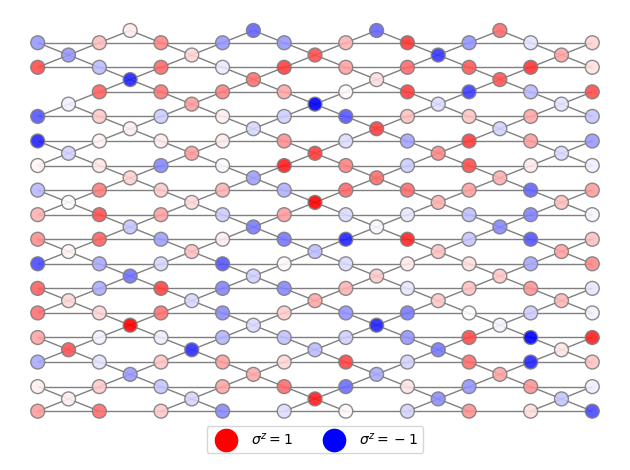

In [119]:
#plot the Kagome lattice graph with a certain response in mind
#this is for an average on each site to be shown with spatial resolution
avg_config = np.mean(all_configs, axis = 0)
#avg_config = all_configs[10]
#--- 1 -- 
#make a generic response
dict_response = {}
m = 0
for key in final_qubit_dictionary.keys():
    dict_response.update({key:avg_config[m]})
    m += 1

cvals  = [-1, 0, 1]
colors = ["blue","white","red"]

import matplotlib.colors as mc

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mc.LinearSegmentedColormap.from_list("", tuples)

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
qubits_val = []
qubit_colors = []
for i in range(len(final_qubit_dictionary)):
    qubit_colors.append((dict_response[test_response_qubits[i]] + 1)/2)
    qubits_val.append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == 1.0:
    #     qubits_val[0].append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == -1.0:
    #     qubits_val[1].append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == 0.0:
    #     qubits_val[2].append(test_response_qubits[i])

#draw the graph with the specific nodes in red or blue

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
ColorLegend = {r'$\sigma^z = 1$' : "red", r'$\sigma^z = -1$' : "blue"
#, r'absent' : "white"
}
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[-2],'o', markersize = 16, color=ColorLegend[label],label=label)
ax.plot([0], [-2], 'o', markersize = 20, markerfacecolor='white', markeredgecolor='white', label='')

options = {"edgecolors": "tab:gray", "node_size": 100, "alpha": 0.9}
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[0], node_color="tab:red", **options, ax=ax)
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[1], node_color="tab:blue", **options, ax=ax)
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[2], node_color="white", **options, ax=ax)
nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val, node_color=qubit_colors, **options, ax=ax, cmap = cmap)

# edges
nx.draw_networkx_edges(Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# Create a custom legend with colored markers

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(bbox_to_anchor =(0.5,0.0),loc='lower center', ncol=3, fontsize = 10)



plt.tight_layout()
plt.axis("off")
plt.show()

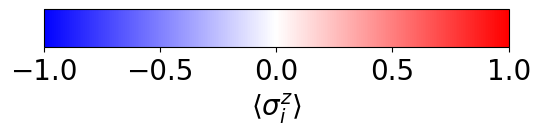

In [120]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.set_label( label=r'$\langle \sigma_i^z \rangle$', fontsize=20)

# Perform Fourier transforms

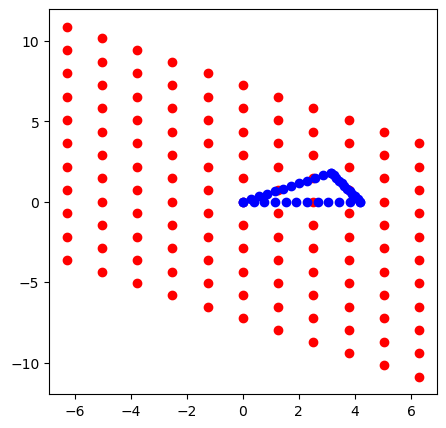

In [306]:
def momentum_grid_kagome(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
        b2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-1, 1, N)
        points2 = np.linspace(-1, 1, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals

def momentum_grid(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1,0])
        b2 = 2*np.pi * np.array([0, 1])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-0.5, 0.5, N)
        points2 = np.linspace(-0.5, 0.5, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals

def path_Kagome(N):
    # Define the reciprocal lattice vectors
    b1 = (2*np.pi/3)*np.array([1, -1/np.sqrt(3)])
    b2 = (2*np.pi/3)*np.array([1, 1/np.sqrt(3)])

    # Define the high-symmetry points
    Gamma = np.array([0, 0])
    #K = (4*np.pi/9)*np.array([1, 1/np.sqrt(3)])
    #G = (2*np.pi/3)*np.array([1, 0])
    K = (4*np.pi/3)*np.array([1, 0])
    G = (4*np.pi/3)*(np.array([1, 0]) + np.array([np.cos(2*np.pi/6), np.sin(2*np.pi/6)]))/2

    # Define the number of points between Gamma-K and K-Gamma'
    # Generate the path
    path = [Gamma]
    path += [Gamma + (i/N)*(K-Gamma) for i in range(1, N+1)]
    path += [K]
    path += [K + (i/N)*(G-K) for i in range(1, N+1)]
    path += [G]
    path += [G + (i/N)*(Gamma-G) for i in range(1, N+1)]

    # Convert the path to Cartesian coordinates
    path_cart = path
    kx_vals = []
    ky_vals = []
    for point in path_cart:
        kx_vals.append(point[0])
        ky_vals.append(point[1])

    return path_cart, kx_vals, ky_vals

def momentum_grid_kagome_scale(N, ascale):
        # Reciprocal lattice vectors
        b1 = 2*np.pi/ascale * np.array([1, -1/np.sqrt(3)])
        b2 = 2*np.pi/ascale * np.array([0, 2/np.sqrt(3)])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-1, 1, N)
        points2 = np.linspace(-1, 1, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals


#plot the scatter of the kx, ky points that have to be run over
total_K, kx_vals, ky_vals = momentum_grid_kagome(11)
#total_K, kx_vals, ky_vals = momentum_grid(41)
plt.scatter(kx_vals, ky_vals, label = '2D points', c = 'red')
total_K_again, kx, ky = path_Kagome(11)
plt.scatter(kx, ky, label = 'Line', c = 'blue')


Doing the fourier transform of the *average* configuration

Text(0, 0.5, '$K_y$')

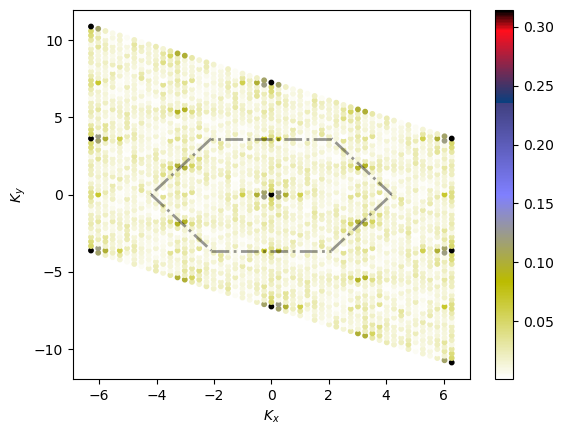

In [128]:
total_K, kx_vals, ky_vals = momentum_grid_kagome(51)

#structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
S2_spin = np.zeros(len(total_K))

#response_analyzed = best_array_dict
avg_config = np.mean(all_configs, axis = 0)
#avg_config = all_configs[10]
#--- 1 -- 
#make a generic response
response_analyzed = {}
m = 0
for key in final_qubit_dictionary.keys():
    response_analyzed.update({key:avg_config[m]})
    m += 1

for kp in range(len(total_K)):
    val = 0
    for q1 in final_qubit_dictionary.keys():
        kpoint = total_K[kp]
        r1 = final_qubit_dictionary[q1]
        val += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
    val = val/len(final_qubit_dictionary)
    S2_spin[kp] = abs(val)


#norm = plt.Normalize(0,len(test_response_qubits))
cmap = plt.cm.get_cmap('gist_stern_r')
plt.scatter(kx_vals, ky_vals, s=10, c=S2_spin, cmap=cmap)
plt.colorbar()
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.xlabel(r'$K_x$')
plt.ylabel(r'$K_y$')


Average of S(q) over all the available configurations: this is needed for the full structure factor

In [144]:
def Sq_for_record(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component

    total_K, kx_vals, ky_vals = momentum_grid_kagome(L_Kpoints)

    structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    structure_factor_mK = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S_spin = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))

    num_reads = len(all_record_configs)

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})
        avg = 0.0
        #calculate_avg = False
        #if calculate_avg == True:
        #    for q1 in qubit_dictionary.keys():
        #        avg += response_analyzed[q1]
        #    avg = avg / len(qubit_dictionary)

        for kp in range(len(total_K)):
            val_K = 0
            val_mK = 0
            for q1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                r1 = qubit_dictionary[q1]
                val_K += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
                val_mK += np.exp(-1j*np.dot(kpoint, r1))*(response_analyzed[q1])
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += val_K
            structure_factor_mK[kp] += val_mK
            S_spin[kp] += abs(val_K)
            S2_spin[kp] += val_K*val_mK
        if k % (num_reads // 10) == 0:
            print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    structure_factor_mK = structure_factor / num_reads
    S_spin = S_spin / num_reads
    S2_spin = S2_spin / num_reads

    return total_K, kx_vals, ky_vals, S_spin, S2_spin, structure_factor, structure_factor_mK
    

Calculate it over N points

In [145]:
numKpoints = 11
feed_in_configs = all_configs[0:500]
total_K, kx_vals, ky_vals, S_spin, S2_spin, structure_factor, structure_factor_mK = Sq_for_record(feed_in_configs, final_qubit_dictionary, qubit_variables, numKpoints)

Done with reads:  0
Done with reads:  50
Done with reads:  100
Done with reads:  150
Done with reads:  200
Done with reads:  250
Done with reads:  300
Done with reads:  350
Done with reads:  400
Done with reads:  450


Text(0.5, 1.0, '$S(q)$, with 1st Brillouin Zone')

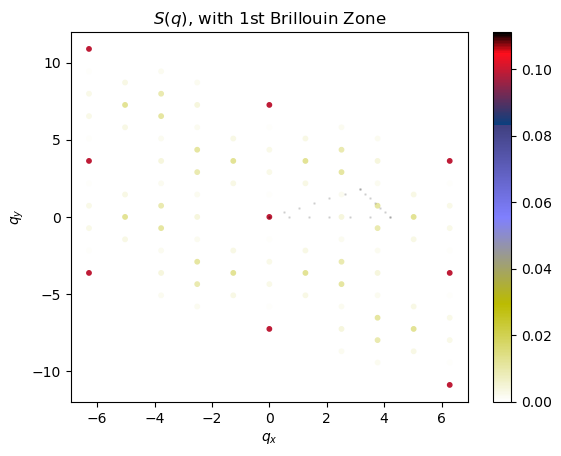

In [151]:
norm = plt.Normalize(0,(1/3)**2)
cmap = plt.cm.get_cmap('gist_stern_r')
#finalSQ_spin = np.absolute(structure_factor)
finalSQ_spin = np.absolute(S2_spin)
#finalSQ = final_spin_Q2 - final_spin_Q**2
plt.scatter(kx_vals, ky_vals, s=10, c=finalSQ_spin, cmap=cmap, norm=norm)
plt.colorbar()
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
#for j in range(6):
#    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
#     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
total_K_again, kx, ky = path_Kagome(6)
for i in range(len(total_K_again)):
    plt.scatter(*total_K_again[i], color = 'black', s = 1, alpha = 0.1)
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.title(r'$S(q)$, with 1st Brillouin Zone')

Interpolation Scheme


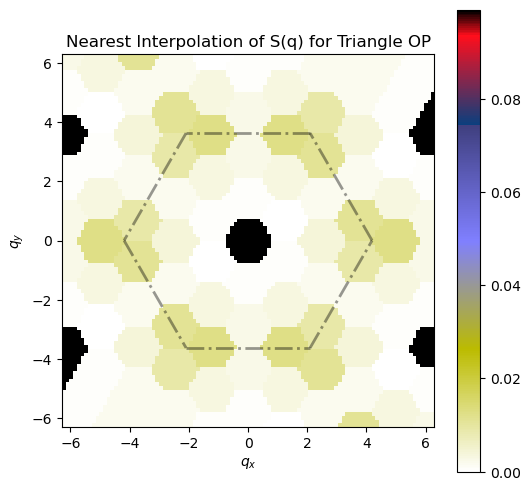

In [148]:
from scipy.interpolate import griddata
xlim = np.linspace(-2*np.pi, 2*np.pi, 100)
ylim = np.linspace(-2*np.pi, 2*np.pi, 100)
#xlim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
#ylim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
grid_x, grid_y = np.meshgrid(xlim, ylim, indexing='ij')
points = total_K
values = finalSQ_spin
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
#possible methods: nearest, square, cubic


#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin='lower')
#plt.plot(points[:, 0], points[:, 1], 'k.', ms=1)   # data
#plt.title('Original')
extent_plot = (-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi)
norm = plt.Normalize(0,np.max(values))

cmap = plt.cm.get_cmap('gist_stern_r')
plt.imshow(grid_z0.T, extent=extent_plot, origin='lower', cmap = cmap, norm = norm)
plt.title('Nearest Interpolation of S(q) for Triangle OP')
plt.colorbar()
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])], [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)

#total_K_again, kx, ky = path_Kagome(11)
#for i in range(20):
#    plt.scatter(*total_K_again[i], color = 'black', s = 5)
plt.gcf().set_size_inches(6, 6)
plt.show()

Line cut along the Gamma - K-M points

In [203]:
def line_BZ(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component

    total_K, kx_vals, ky_vals = path_Kagome(L_Kpoints)

    structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    # structure_factor_mK = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S_spin = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S3_spin = np.zeros(len(total_K))

    num_reads = len(all_record_configs)

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})
        avg = 0.0
        #calculate_avg = False
        #if calculate_avg == True:
        #    for q1 in qubit_dictionary.keys():
        #        avg += response_analyzed[q1]
        #    avg = avg / len(qubit_dictionary)

        for kp in range(len(total_K)):
            val_K = 0
            val_mK = 0
            for q1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                r1 = qubit_dictionary[q1]
                val_K += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
                val_mK += np.exp(-1j*np.dot(kpoint, r1))*(response_analyzed[q1])
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += val_K
            # structure_factor_mK[kp] += val_mK
            S_spin[kp] += abs(val_K)
            S2_spin[kp] += val_K*val_mK
            S3_spin[kp] += abs(val_K*val_mK)
        if k % (num_reads // 10) == 0:
            print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    # structure_factor_mK = structure_factor / num_reads
    S_spin = S_spin / num_reads
    S2_spin = S2_spin / num_reads
    S3_spin = S3_spin / num_reads

    return total_K, kx_vals, ky_vals, S_spin, S2_spin, S3_spin, structure_factor

Calculate line cut S(q) - note don't do too many points otherwise there will be spurious oscillations in Q

In [224]:
numKpoints = 40
feed_in_configs = all_configs[0:500]
total_K, kx_vals, ky_vals, S_spin, S2_spin, S3_spin, structure_factor = line_BZ(feed_in_configs, final_qubit_dictionary, qubit_variables, numKpoints)
print('done')

Done with reads:  0
Done with reads:  50
Done with reads:  100
Done with reads:  150
Done with reads:  200
Done with reads:  250
Done with reads:  300
Done with reads:  350
Done with reads:  400
Done with reads:  450
done


Make some plots

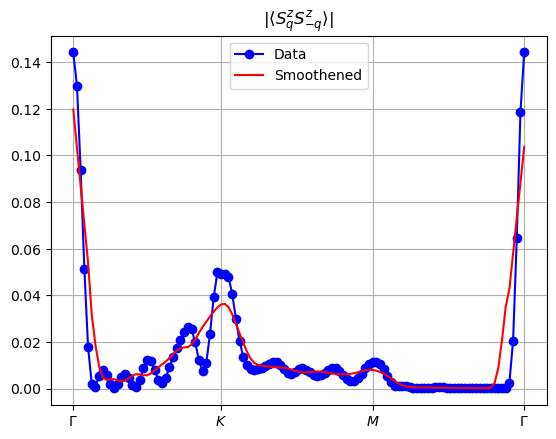

In [263]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]

from scipy.signal import savgol_filter
yhat = savgol_filter(abs(S2_spin), 10, 1)

plt.plot(abs(S2_spin), marker = 'o', c = 'blue', label = 'Data')
plt.plot(yhat, linestyle = '-', c = 'red', label = 'Smoothened')
plt.xticks(ticks = xticks, labels = xticks_label);
plt.legend()
plt.title(r'$|\langle S^z_q S^z_{-q} \rangle |$')
plt.grid()

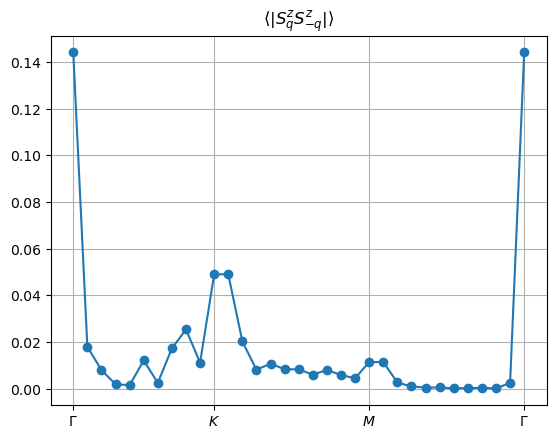

In [207]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
plt.plot(S3_spin, marker = 'o')
plt.xticks(ticks = xticks, labels = xticks_label);
plt.title(r'$\langle |S^z_q S^z_{-q}| \rangle $')
plt.grid()

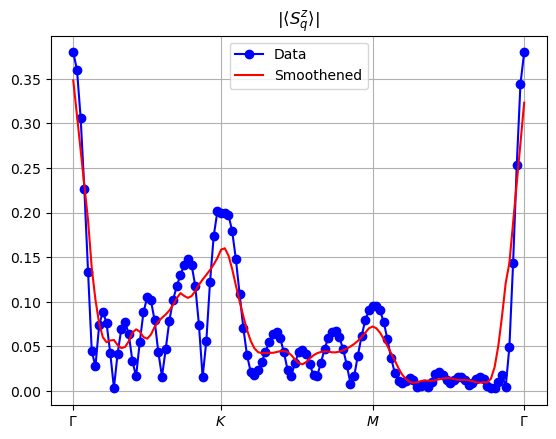

In [266]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
from scipy.signal import savgol_filter
yhat = savgol_filter(abs(structure_factor), 10, 1)

plt.plot(abs(structure_factor), marker = 'o', c = 'blue', label = 'Data')
plt.plot(yhat, linestyle = '-', c = 'red', label = 'Smoothened')
plt.legend()
plt.xticks(ticks = xticks, labels = xticks_label);
plt.title(r'$|\langle S^z_q \rangle |$')
plt.grid()

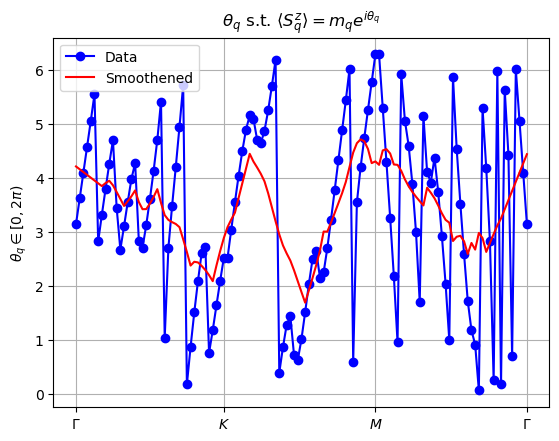

In [271]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
#yval = np.angle(structure_factor)
yval = np.mod(np.angle(structure_factor), 2*np.pi)

yhat = savgol_filter(yval, 15, 1)

plt.plot(yval, marker = 'o', c = 'blue', label = 'Data')
plt.plot(yhat, linestyle = '-', c = 'red', label = 'Smoothened')
plt.legend()
plt.xticks(ticks = xticks, labels = xticks_label);
plt.title(r'$\theta_q$ s.t. $\langle S^z_q \rangle = m_q e^{i\theta_q}$')
plt.ylabel(r"$\theta_q \in [0,2\pi)$")
plt.grid()

# Unit cell structure factor

In [280]:
unit_cells = np.load("./data/unitcells.npy", allow_pickle=True).flat[0]
unit_cells_down = np.load("./data/unitcells_down.npy", allow_pickle=True).flat[0]

best_array = all_configs[0]

#make as dict
best_array_dict = {}
for j in range(len(best_array)):
    best_array_dict.update({qubit_variables[j]:best_array[j]})

locs = []
arrows = []
colors = []
fac = 0.5
all_colors = ["red", "blue", "green", "black"]

vec1 = 2*np.array([1.0, 0.0])
vec2 = 2*np.array([0.5, 0.8660254])

for r1 in unit_cells.keys():
    three_sites = unit_cells[r1]
    r1vec = np.array(r1)
    locs.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254])))
    all_data = [best_array_dict[three_sites[i]] for i in range(3)]
    if all_data == [1,-1,-1]:
        arrow_triangle = np.array([1,0])
        col_here = all_colors[0]
    elif all_data == [-1,1,-1]:
        arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
        col_here = all_colors[1]
    elif all_data == [-1,-1,1]:
        arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
        col_here = all_colors[2]
    else :
        arrow_triangle = np.array([0,0])
        col_here = all_colors[3]
    arrows.append(fac*arrow_triangle)
    colors.append(col_here)

# for r1 in unit_cells_down.keys():
#     three_sites = unit_cells_down[r1]
#     r1vec = np.array(r1)
#     locs.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(vec2 + np.array([0, 0.8660254])))
#     all_data = [best_array_dict[three_sites[i]] for i in range(3)]
#     if all_data == [1,-1,-1]:
#         arrow_triangle = np.array([1,0])
#         col_here = all_colors[0]
#     elif all_data == [-1,1,-1]:
#         arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
#         col_here = all_colors[1]
#     elif all_data == [-1,-1,1]:
#         arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
#         col_here = all_colors[2]
#     else :
#         arrow_triangle = np.array([0,0])
#         col_here = all_colors[3]
#     arrows.append(fac*arrow_triangle)
#     colors.append(col_here)

locs_down = []
for r1 in unit_cells_down.keys():
    three_sites = unit_cells_down[r1]
    r1vec = np.array(r1)
    locs_down.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(vec2 + np.array([0, 0.8660254])))

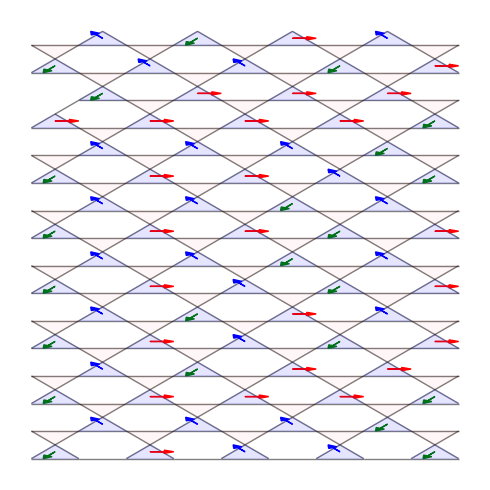

In [282]:
#draw the graph with the specific nodes in red or blue

plt.ion()
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"]=100

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
options = {"edgecolors": "none", "node_size": 60, "alpha": 1.0}
# edges
nx.draw_networkx_edges(Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# add the arrows
distance1 = -0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254]))
distance2 = 0.5*( np.array([0, 0.8660254]))
distance3 = 0.5*(np.array([1.0, 0.0]) + np.array([0, -0.8660254]))

for i in range(len(locs)):
    #sites_of_triangle = [locs[i] + distance1,locs[i] + distance2, locs[i] + distance3 ]
    #t1 = plt.Polygon(sites_of_triangle, color="black", alpha = 0.1)
    #plt.gca().add_patch(t1)
    plt.arrow(*locs[i], *arrows[i], head_width=0.2, head_length=0.2, fc=colors[i], ec=colors[i], length_includes_head = True)

for i in range(len(locs)):
    sites_of_triangle = [locs[i] + distance1,locs[i] + distance2, locs[i] + distance3 ]
    t1 = plt.Polygon(sites_of_triangle, color="blue", alpha = 0.1)
    ax.add_patch(t1)

for i in range(len(locs_down)):
    sites_of_triangle = [locs_down[i] - distance1,locs_down[i] - distance2, locs_down[i] - distance3 ]
    t1 = plt.Polygon(sites_of_triangle, color="red", alpha = 0.03)
    ax.add_patch(t1)
    #ax.scatter(locs_down[i][0], locs_down[i][1], color = 'black', s=10)

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')
plt.tight_layout()
plt.axis("off")
plt.show()

*Need to perform the sum over all of these triangles and do a Fourier transform*

Perform the Fourier transform of that triangle order for all configurations

In [318]:
def Triangle_q_for_record(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component
    ascale = 2;
    total_K, kx_vals, ky_vals = momentum_grid_kagome_scale(L_Kpoints, ascale)

    structure_factor = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    num_reads = len(all_record_configs)

    vec1 = 2*np.array([1.0, 0.0])
    vec2 = 2*np.array([0.5, 0.8660254])

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})

        for kp in range(len(total_K)):
            val_K = np.array([0.0, 0.0]) + 1j*np.array([0.0, 0.0])
            val_mK = np.array([0.0, 0.0]) + 1j*np.array([0.0, 0.0])
            for r1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                three_sites = qubit_dictionary[r1]
                r1vec_temp = np.array(r1)
                r1vec = r1vec_temp[0]*vec1 + r1vec_temp[1]*vec2 + 0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254]))
                all_data = [response_analyzed[three_sites[i]] for i in range(3)]
                if all_data == [1,-1,-1]:
                    arrow_triangle = np.array([1,0])
                elif all_data == [-1,1,-1]:
                    arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
                elif all_data == [-1,-1,1]:
                    arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
                else :
                    arrow_triangle = np.array([0,0])
                #partA = response_analyzed[three_sites[0]]*np.array([1,0])
                #partB = response_analyzed[three_sites[1]]*np.array([-1/2,np.sqrt(3)/2])
                #partC = response_analyzed[three_sites[2]]*np.array([-1/2, -np.sqrt(3)/2])
                #arrow_triangle = partA + partB + partC
                val_K += np.exp(1j*np.dot(kpoint, r1vec))*(arrow_triangle)
                val_mK += np.exp(-1j*np.dot(kpoint, r1vec))*(arrow_triangle)
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += np.linalg.norm(val_K)
            S2_spin[kp] += np.dot(val_K,val_mK)
        if num_reads != 1:
            if k % (num_reads // 10) == 0:
                print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    S2_spin = S2_spin / num_reads

    return total_K, kx_vals, ky_vals, S2_spin, structure_factor
    

In [322]:
numKpoints = 37
#feed_in_configs = np.array([all_configs[0]])
feed_in_configs = all_configs[0:100]
total_K, kx_vals, ky_vals, S2_spin, structure_factor = Triangle_q_for_record(feed_in_configs, unit_cells, qubit_variables, numKpoints)

Done with reads:  0
Done with reads:  10
Done with reads:  20
Done with reads:  30
Done with reads:  40
Done with reads:  50
Done with reads:  60
Done with reads:  70
Done with reads:  80
Done with reads:  90


Plotting the bare Q-space data - what is the Brillouin Zone for this new lattice?? It is half the BZ of the original kagome, because the translation vectors are twice in length.

Text(0.5, 1.0, '$\\langle|\\vec{\\Phi}(q)|\\rangle$')

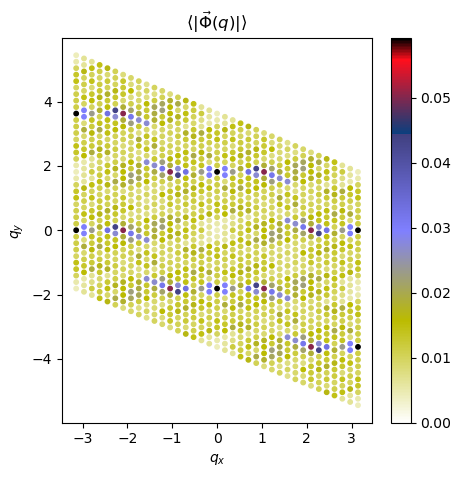

In [326]:
cmap = plt.cm.get_cmap('gist_stern_r')
#finalSQ = np.absolute(S2_spin) - np.absolute(structure_factor)*np.absolute(structure_factor_mK)
finalSQ = abs(S2_spin)
#finalSQ = structure_factor
#finalSQ = final_spin_Q2 - final_spin_Q**2
norm = plt.Normalize(0,np.max(finalSQ))

plt.scatter(kx_vals, ky_vals, s=10, c=finalSQ, cmap=cmap, norm = norm)
plt.colorbar()

plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.title(r'$\langle|\vec{\Phi}(q)|\rangle$')

Interpolation

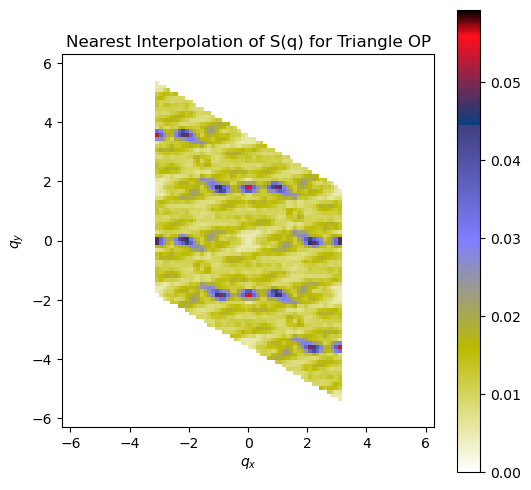

In [329]:
from scipy.interpolate import griddata
xlim = np.linspace(-2*np.pi, 2*np.pi, 100)
ylim = np.linspace(-2*np.pi, 2*np.pi, 100)
#xlim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
#ylim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
grid_x, grid_y = np.meshgrid(xlim, ylim, indexing='ij')
points = total_K
#values = structure_factor
values = np.absolute(S2_spin)
grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')
#possible methods: nearest, square, cubic


#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin='lower')
#plt.plot(points[:, 0], points[:, 1], 'k.', ms=1)   # data
#plt.title('Original')
extent_plot = (-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi)
norm = plt.Normalize(0,np.max(values))

cmap = plt.cm.get_cmap('gist_stern_r')
plt.imshow(grid_z0.T, extent=extent_plot, origin='lower', cmap = cmap, norm = norm)
plt.title('Nearest Interpolation of S(q) for Triangle OP')
plt.colorbar()
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
# theta_list = [2*np.pi*i/6 for i in range(7)]
# lside = 4*np.pi/3
# for j in range(6):
#     plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
#      [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.gcf().set_size_inches(6, 6)
plt.show()

Shows some kind of nematic order - due to lattice periodicity in a given direction